# Input Data Information

# Package Import

In [2]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras import activations 
from keras.layers import Dropout
from keras.constraints import maxnorm

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

import time

import datetime, os

import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection
from sklearn import preprocessing


from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# settings
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.4f}'.format

# CS767 Final Presentation - Patrick Tyson

## Data Sources
This data set is pulled from several different sources:

1.   All play-by-play data is pulled from the nflscrapR .csv files available on the project's GitHub page (https://github.com/ryurko/nflscrapR-data/tree/master/play_by_play_data/regular_season)

2.   All games data is pulled from the nflscrapR .csv files available on the project's GitHub page (https://github.com/ryurko/nflscrapR-data/tree/master/games_data/regular_season)

3. All roster or player data is pulled from the nflscrapR .csv files available on the project's GitHub page (https://github.com/ryurko/nflscrapR-data/tree/master/roster_data/regular_season)

4. All data related to the NFL Draft is from Pro-Football-Reference (https://www.pro-football-reference.com/play-index/draft-finder.cgi)

5. All data related to the NFL Combine is from Pro-Football-Reference (https://www.pro-football-reference.com/play-index/nfl-combine-results.cgi)







## Data Aggregation
After this data was pulled together, I used aggregation and summary tools from Alteryx to prep the data for feeding the Neural Network. I spent many hours trying via Python to accomplish this task, but ran into countless issues with Pandas groupby and agg functions, and was unable to find a simple way to compute multi-row calculations like 3-game averages. This is how I typically work through projects in Python or R, prepare the data quickly and easily in Alteyrx, then run Python/R on the cleansed data file. I did ask Dr. Braude about using external tools to prepare our data file, and he stressed that the training of the Neural Network is more important in this process than the preparation of the data set.  

# Data Import and Preparation

## Importing File

In [5]:
from google.colab import files
uploaded = files.upload()

Saving CS767_NN_Input_Data_trimmed.csv to CS767_NN_Input_Data_trimmed.csv


In [0]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['CS767_NN_Input_Data_trimmed.csv']))

## Data Segmentation

In [0]:
# Training - Test (70-15-15%)
train, val_and_test = sklearn.model_selection.train_test_split(df, test_size=0.3, random_state=456, shuffle=True)

# Need to split val and test (30%) up
val, test = sklearn.model_selection.train_test_split(val_and_test, test_size=0.5, random_state=456, shuffle=True)

In [0]:
# Neural Network DATA 
Xtrain = train.iloc[:,7:43].astype(np.float32)
Xval = val.iloc[:,7:43].astype(np.float32)
Xtest = test.iloc[:,7:43].astype(np.float32)
Ytrain = train.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
Yval = val.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
Ytest = test.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
#Xtrain

## Data Normalization - Standard Scaler

In [0]:
# Getting Summary Statistics for Rescaling Outputs
train_mean = np.mean(Ytrain)
train_mdn = np.median(Ytrain)
train_stdev = np.std(Ytrain)
val_mean = np.mean(Yval)
val_mdn = np.median(Yval)
val_stdev = np.std(Yval)
test_mean = np.mean(Ytest)
test_mdn = np.median(Ytest)
test_stdev = np.std(Ytest)
train_mean

7.821415

In [0]:
# Normalizing data using Standard Scaler
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.RobustScaler()

# Normalizing training, validation, and test data individually
Xtrain_norm = scaler.fit_transform(Xtrain)
Xval_norm = scaler.fit_transform(Xval)
Xtest_norm = scaler.fit_transform(Xtest)
Ytrain_norm = scaler.fit_transform(Ytrain)
Yval_norm = scaler.fit_transform(Yval)
Ytest_norm = scaler.fit_transform(Ytest)

# Building Initial Neural Network

All "Building Initial Neural Network" tuning subsections adaptaed from: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Model Structure Hyperparameters

In [0]:
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1

n_epochs = 50

## Model Structure Function

In [0]:
# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

## Creating Model

In [0]:
# Set random seed
np.random.seed(123)

# create model
nn = KerasRegressor(build_fn=create_network)

In [0]:
history = nn.fit(x = Xtrain_norm, verbose=0, y = Ytrain_norm,
       epochs=n_epochs
       , validation_data = (Xval_norm, Yval_norm)
)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,0.9157,0.9157,0.7728,0.9342,0.9342,0.7792,0
1,0.9032,0.9032,0.7758,0.8940,0.8940,0.7693,1
2,0.9010,0.9010,0.7728,0.8819,0.8819,0.7675,2
3,0.9001,0.9001,0.7745,0.8741,0.8741,0.7634,3
4,0.9013,0.9013,0.7745,0.8694,0.8694,0.7625,4
5,0.8982,0.8982,0.7748,0.8637,0.8637,0.7602,5
6,0.9007,0.9007,0.7763,0.8610,0.8610,0.7598,6
7,0.9017,0.9017,0.7773,0.8571,0.8571,0.7592,7
8,0.9033,0.9033,0.7792,0.8531,0.8531,0.7570,8
9,0.9052,0.9052,0.7763,0.8508,0.8508,0.7547,9


In [0]:
hist.loc[hist['val_mean_squared_error'].idxmin()]

val_loss                  0.8982
val_mean_squared_error    0.8982
val_mean_absolute_error   0.7748
loss                      0.8637
mean_squared_error        0.8637
mean_absolute_error       0.7602
epoch                     5.0000
Name: 5, dtype: float64

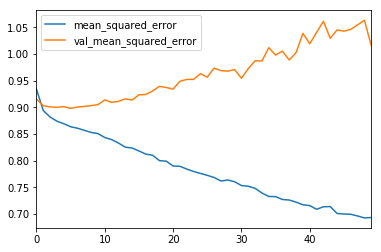

In [0]:
initial_nn_plot_MSE = hist.iloc[:, [4,1]].plot.line()
initial_nn_plot_MSE

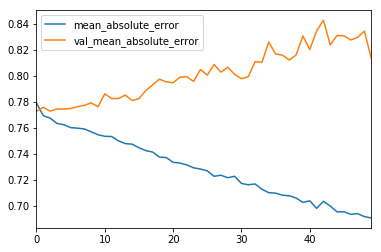

In [0]:
initial_nn_plot_MAE = hist.iloc[:, [5,2]].plot.line()
initial_nn_plot_MAE

# Feature Selection with Random Forest

All Feature Selection subsections adapted from: https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [0]:
rfr = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the random forest regressor
rfr.fit(Xtrain_norm, Ytrain_norm[:,0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
# Print the name and gini importance of each feature
for feature in zip(Xtrain.columns, rfr.feature_importances_):
    print(feature)

('Height_Inches', 0.014128901086478943)
('Wt', 0.02435644765705676)
('40YD', 0.025692274119113914)
('Vertical', 0.021557301715920723)
('Years_in_League', 0.01854844589716826)
('OPP_DEF__Fantasy_Points_Allowed__3_Games', 0.03498069113503314)
('OPP_DEF__Fantasy_Points_Allowed__Last_Game', 0.03885272876478954)
('OWN_DEF__Fantasy_Points_Allowed__3_Games', 0.03488740489772494)
('OWN_DEF__Fantasy_Points_Allowed__Last_Game', 0.036331056835409624)
('Total_Yards__3_Games', 0.04631520147390111)
('Total_Receptions__3_Games', 0.06487109961726935)
('Total_Touchdowns__3_Games', 0.009808593963760983)
('Targets__3_Games', 0.1581219014836574)
('Avg_Depth_of_Target__3_Games', 0.03318744129448801)
('Avg_Score_Differential__3_Games', 0.04440500752352339)
('3rd_Down_Targets__3_Games', 0.02342110575312449)
('4th_Down_Targets__3_Games', 0.0042886681148468575)
('Short_Targets__3_Games', 0.018141918743126508)
('Deep_Targets__3_Games', 0.01643571652452778)
('YBC__3_Games', 0.028545198068871874)
('YAC__3_Games',

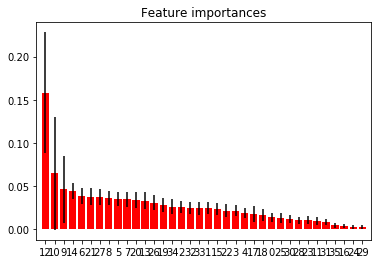

In [0]:
# Plotting Feature Importances
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtrain_norm.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtrain_norm.shape[1]), indices)
plt.xlim([-1, Xtrain_norm.shape[1]])
plt.show()

In [0]:
# Create a selector object that will use the random forest regressor to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(rfr, threshold=0.03)

# Train the selector
sfm.fit(Xtrain_norm, Ytrain_norm[:,0])

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=1000, n_jobs=-1,
                                                oob_score=False, random_state=0,
                                                verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=0.03)

In [0]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(Xtrain.columns[feature_list_index])

OPP_DEF__Fantasy_Points_Allowed__3_Games
OPP_DEF__Fantasy_Points_Allowed__Last_Game
OWN_DEF__Fantasy_Points_Allowed__3_Games
OWN_DEF__Fantasy_Points_Allowed__Last_Game
Total_Yards__3_Games
Total_Receptions__3_Games
Targets__3_Games
Avg_Depth_of_Target__3_Games
Avg_Score_Differential__3_Games
YAC__3_Games
Fantasy_Points_Scored__3_Games
Avg_Depth_of_Target__Last_Game
Avg_Score_Differential__Last_Game


In [0]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(Xtrain_norm)
X_important_test = sfm.transform(Xtest_norm)
X_important_val = sfm.transform(Xval_norm)

In [0]:
X_important_val.shape

(961, 13)

In [0]:
# Create a new random forest classifier for the most important features
rfr_important = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
rfr_important.fit(X_important_train, Ytrain_norm[:,0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
# Apply The Full Featured Regressor To The Test Data
y_pred = rfr.predict(Xtest_norm)

# View The MSE Of Our Full Feature (4 Features) Model
print(mean_squared_error(Ytest_norm, y_pred))
print(median_absolute_error(Ytest_norm, y_pred))

0.8556813724458473
0.6150870700343511


In [0]:
# Apply The Limited Featured Classifier To The Test Data
y_important_pred = rfr_important.predict(X_important_test)

# View The MSE Of Our Limited Feature (2 Features) Model
print(mean_squared_error(Ytest_norm, y_important_pred))
print(median_absolute_error(Ytest_norm, y_important_pred))

0.8740943581494037
0.6005775118470192


## Running NN on RF Selected Features

### Model Structure Hyperparameters

In [0]:
n_inputs = len(X_important_train)
n_features = len(X_important_train[0])
n_hidden1 = len(X_important_train[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1

n_epochs = 50

### Model Structure Function

In [0]:
# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

## Creating Model

In [0]:
# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=25)

In [0]:
history_rf = nn.fit(x = X_important_train, verbose=0, y = Ytrain_norm,
       epochs=200
       , validation_data = (X_important_val, Yval_norm)
)

In [0]:
hist_rf = pd.DataFrame(history_rf.history)
hist_rf['epoch'] = history_rf.epoch
hist_rf

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,1.0003,1.0003,0.7900,1.0002,1.0002,0.7800,0
1,1.0003,1.0003,0.7900,0.9999,0.9999,0.7797,1
2,0.9949,0.9949,0.7913,0.9992,0.9992,0.7796,2
3,0.8999,0.8999,0.7730,0.9140,0.9140,0.7751,3
4,0.8972,0.8972,0.7705,0.8882,0.8882,0.7701,4
5,0.8967,0.8967,0.7736,0.8829,0.8829,0.7675,5
6,0.8985,0.8985,0.7765,0.8787,0.8787,0.7666,6
7,0.8938,0.8938,0.7749,0.8767,0.8767,0.7643,7
8,0.8954,0.8954,0.7764,0.8722,0.8722,0.7632,8
9,0.9130,0.9130,0.7907,0.8720,0.8720,0.7630,9


In [0]:
hist_rf.loc[hist_rf['val_mean_squared_error'].idxmin()]

val_loss                   0.8919
val_mean_squared_error     0.8919
val_mean_absolute_error    0.7730
loss                       0.8643
mean_squared_error         0.8643
mean_absolute_error        0.7618
epoch                     12.0000
Name: 12, dtype: float64

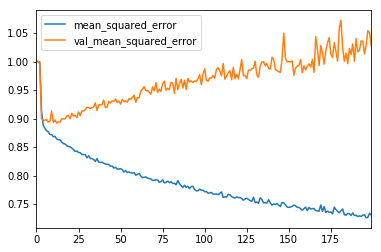

In [0]:
rf_nn_plot_MSE = hist_rf.iloc[:, [4,1]].plot.line()
rf_nn_plot_MSE

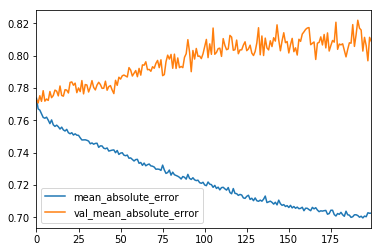

In [0]:
rf_nn_plot_MAE = hist_rf.iloc[:, [5,2]].plot.line()
rf_nn_plot_MAE

# Hyperparameter Tuning

All hyperparameter tuning subsections adaptaed from: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Batch Size and Number of Epochs

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
batch_size = [50, 100, 250]
epochs = [10, 25, 50]

# Building Grid
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=-1)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.893508 using {'batch_size': 100, 'epochs': 10}
-0.906075 (0.025970) with: {'batch_size': 50, 'epochs': 10}
-0.996471 (0.041394) with: {'batch_size': 50, 'epochs': 25}
-1.083818 (0.056757) with: {'batch_size': 50, 'epochs': 50}
-0.893508 (0.027216) with: {'batch_size': 100, 'epochs': 10}
-0.950693 (0.043341) with: {'batch_size': 100, 'epochs': 25}
-1.020825 (0.024739) with: {'batch_size': 100, 'epochs': 50}
-0.897501 (0.028645) with: {'batch_size': 250, 'epochs': 10}
-0.910529 (0.037353) with: {'batch_size': 250, 'epochs': 25}
-0.983384 (0.037062) with: {'batch_size': 250, 'epochs': 50}


#### Optimal Values

##### Batch Size = 100
##### Number of Epochs = 10

## Optimization Algorithm

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(optimizer='adam'):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Nadam']

# Building Grid
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=-1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.931406 using {'optimizer': 'Adagrad'}
-0.938579 (0.063326) with: {'optimizer': 'SGD'}
-1.010800 (0.029448) with: {'optimizer': 'RMSprop'}
-0.931406 (0.026119) with: {'optimizer': 'Adagrad'}
-1.048644 (0.057657) with: {'optimizer': 'Adam'}
-1.053156 (0.054487) with: {'optimizer': 'Nadam'}


#### Optimal Values

##### Optimizer = SGD

## Learning Rate and Momentum

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(learn_rate=0.01, momentum=0):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.0, 0.1, 0.25]

# Building Grid
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1.002819 using {'learn_rate': 0.1, 'momentum': 0.1}
-1.046279 (0.042569) with: {'learn_rate': 0.001, 'momentum': 0.0}
-1.049379 (0.012329) with: {'learn_rate': 0.001, 'momentum': 0.1}
-1.017615 (0.042249) with: {'learn_rate': 0.001, 'momentum': 0.25}
-1.021097 (0.020548) with: {'learn_rate': 0.01, 'momentum': 0.0}
-1.019444 (0.011505) with: {'learn_rate': 0.01, 'momentum': 0.1}
-1.064269 (0.015605) with: {'learn_rate': 0.01, 'momentum': 0.25}
-1.020066 (0.041608) with: {'learn_rate': 0.1, 'momentum': 0.0}
-1.002819 (0.008608) with: {'learn_rate': 0.1, 'momentum': 0.1}
-1.037555 (0.011690) with: {'learn_rate': 0.1, 'momentum': 0.25}


#### Optimal Values

##### Learning Rate = 0.1
##### Momentum = 0.1

## Network Weight Initialization

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(init_mode='uniform'):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, kernel_initializer=init_mode, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, kernel_initializer=init_mode, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, kernel_initializer=init_mode, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, kernel_initializer=init_mode, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)

# Building Grid
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.984337 using {'init_mode': 'uniform'}
-0.984337 (0.032595) with: {'init_mode': 'uniform'}
-1.014629 (0.017543) with: {'init_mode': 'lecun_uniform'}
-1.011314 (0.011269) with: {'init_mode': 'normal'}
-1.000000 (0.020576) with: {'init_mode': 'zero'}
-1.044479 (0.047411) with: {'init_mode': 'glorot_normal'}
-1.045773 (0.043035) with: {'init_mode': 'glorot_uniform'}
-1.017475 (0.059907) with: {'init_mode': 'he_normal'}
-1.002737 (0.043526) with: {'init_mode': 'he_uniform'}


#### Optimal Values

##### Weight Initialization = Uniform

## Neuron Activation Function

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(activation='relu'):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation=activation, use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2,  activation=activation, use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3,  activation=activation, use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation=activation))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)

# Building Grid
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.795941 using {'activation': 'linear'}
-2.000000 (0.001212) with: {'activation': 'softmax'}
-0.900014 (0.027005) with: {'activation': 'softplus'}
-0.877997 (0.048707) with: {'activation': 'softsign'}
-1.060909 (0.066199) with: {'activation': 'relu'}
-0.893174 (0.037311) with: {'activation': 'tanh'}
-0.891389 (0.026936) with: {'activation': 'sigmoid'}
-0.882660 (0.027209) with: {'activation': 'hard_sigmoid'}
-0.795941 (0.042408) with: {'activation': 'linear'}


#### Optimal Values

##### Activation Function = Linear

## Dropout Regularization

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(dropout_rate=0.01, weight_constraint=0):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='relu', 
                             kernel_constraint=maxnorm(weight_constraint), 
                             use_bias=True, input_shape=(n_features,)))
    network.add(Dropout(dropout_rate))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='relu', 
                             kernel_constraint=maxnorm(weight_constraint), 
                             use_bias=True))
    network.add(Dropout(dropout_rate))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='relu', 
                             kernel_constraint=maxnorm(weight_constraint), 
                             use_bias=True))
    network.add(Dropout(dropout_rate))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
weight_constraint = [0, 1, 2]
dropout_rate = [0.0, 0.1, 0.2]

# Building Grid
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.891008 using {'dropout_rate': 0.2, 'weight_constraint': 1}
-1.000000 (0.020576) with: {'dropout_rate': 0.0, 'weight_constraint': 0}
-0.976401 (0.022123) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
-1.033513 (0.047523) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
-1.000000 (0.020576) with: {'dropout_rate': 0.1, 'weight_constraint': 0}
-0.906816 (0.023351) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
-0.909789 (0.030800) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
-1.000000 (0.020576) with: {'dropout_rate': 0.2, 'weight_constraint': 0}
-0.891008 (0.024368) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
-0.896379 (0.023916) with: {'dropout_rate': 0.2, 'weight_constraint': 2}


#### Optimal Values

##### Dropout Rate = 0.2
##### Weight Constraint = 1

## Hidden Layer Neurons

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = len(Xtrain_norm[0])
n_hidden2 = 15
n_hidden3 = 10
n_outputs = 1


# Create function returning a compiled network
def create_network(hl1=20, hl2=15, hl3=10):
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=hl1, activation='relu', use_bias=True, input_shape=(n_features,)))

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=hl2, activation='relu', use_bias=True))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=hl3, activation='relu', use_bias=True))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer='Adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn = KerasRegressor(build_fn=create_network,  epochs=50, batch_size=100, verbose=0)

 ### Defining Grid Search Parameters

In [0]:
# Hyperparameters
hl1 = [20]
hl2 = [20]
hl3 = [15, 10 ,5]

# Building Grid
param_grid = dict(hl1=hl1, hl2=hl2, hl3=hl3)
grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=1, cv=3)

### Running Grid Search

In [0]:
# Running Grid Search
grid_result = grid.fit(Xtrain_norm, Ytrain_norm)

### Grid Search Output

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.966048 using {'hl1': 20, 'hl2': 20, 'hl3': 5}
-1.020417 (0.032005) with: {'hl1': 20, 'hl2': 20, 'hl3': 15}
-0.992446 (0.026780) with: {'hl1': 20, 'hl2': 20, 'hl3': 10}
-0.966048 (0.021359) with: {'hl1': 20, 'hl2': 20, 'hl3': 5}


#### Optimal Values

##### Hidden Layer 1 = 20 neurons
##### Hidden Layer 2 = 20 neurons
##### Hidden Layer 3 = 5 neurons

# Running Model with Optimized Functions

## Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = 20
n_hidden2 = 20
n_hidden3 = 5
n_outputs = 1
optimizer = SGD(lr=0.001, momentum=0.1)


# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1), 
                             input_shape=(n_features,)
                             ))
    network.add(Dropout(0.2))
    
    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1)
                             ))
    network.add(Dropout(0.2))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1)
                             ))
    network.add(Dropout(0.2))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(1)

# create model
nn_final = KerasRegressor(build_fn=create_network,  epochs=400, batch_size=100, verbose=0)

In [0]:
history_final = nn_final.fit(x = Xtrain_norm, verbose=0, y = Ytrain_norm
       , validation_data = (Xval_norm, Yval_norm)
)
hist_final = pd.DataFrame(history_final.history)
hist_final['epoch'] = history_final.epoch
hist_final

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,1.0000,1.0000,0.7898,1.0001,1.0001,0.7799,0
1,1.0000,1.0000,0.7898,1.0000,1.0000,0.7798,1
2,1.0000,1.0000,0.7898,1.0000,1.0000,0.7798,2
3,1.0000,1.0000,0.7898,1.0000,1.0000,0.7798,3
4,1.0000,1.0000,0.7898,0.9999,0.9999,0.7798,4
5,1.0000,1.0000,0.7898,0.9999,0.9999,0.7798,5
6,1.0000,1.0000,0.7898,0.9998,0.9998,0.7798,6
7,1.0000,1.0000,0.7898,0.9998,0.9998,0.7798,7
8,1.0001,1.0001,0.7899,0.9998,0.9998,0.7798,8
9,1.0000,1.0000,0.7898,0.9998,0.9998,0.7799,9


In [0]:
hist_final.loc[hist_final['val_mean_squared_error'].idxmin()]

val_loss                    0.8826
val_mean_squared_error      0.8826
val_mean_absolute_error     0.7682
loss                        0.8808
mean_squared_error          0.8808
mean_absolute_error         0.7652
epoch                     398.0000
Name: 398, dtype: float64

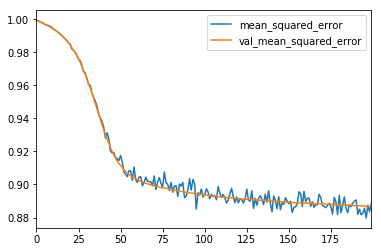

In [0]:
tuned_nn_plot_MSE = hist_final.iloc[:, [4,1]].plot.line()
tuned_nn_plot_MSE

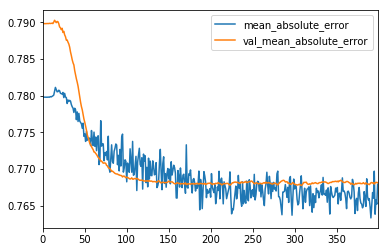

In [0]:
tuned_nn_plot_MAE = hist_final.iloc[:, [5,2]].plot.line()
tuned_nn_plot_MAE

## Evaluating Model on Test Data

In [0]:
test_history = nn_final.fit(x = Xtest_norm, verbose=0, y = Ytest_norm
                      
                      , validation_data = (Xval_norm, Yval_norm)
)
test_hist = pd.DataFrame(test_history.history)
test_hist['epoch'] = test_history.epoch
test_hist

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,0.9974,0.9974,0.7895,0.9985,0.9985,0.8051,0
1,0.9970,0.9970,0.7897,0.9979,0.9979,0.8054,1
2,0.9968,0.9968,0.7898,0.9974,0.9974,0.8054,2
3,0.9966,0.9966,0.7901,0.9976,0.9976,0.8057,3
4,0.9964,0.9964,0.7900,0.9974,0.9974,0.8059,4
5,0.9963,0.9963,0.7902,0.9969,0.9969,0.8059,5
6,0.9961,0.9961,0.7902,0.9964,0.9964,0.8058,6
7,0.9959,0.9959,0.7899,0.9971,0.9971,0.8066,7
8,0.9957,0.9957,0.7900,0.9972,0.9972,0.8059,8
9,0.9955,0.9955,0.7900,0.9962,0.9962,0.8058,9


In [0]:
test_hist.loc[test_hist['val_mean_squared_error'].idxmin()]

val_loss                    0.8936
val_mean_squared_error      0.8936
val_mean_absolute_error     0.7683
loss                        0.9017
mean_squared_error          0.9017
mean_absolute_error         0.7860
epoch                     398.0000
Name: 398, dtype: float64

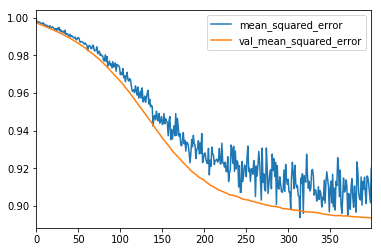

In [0]:
tuned_nn_plot_MSE_test = test_hist.iloc[:, [4,1]].plot.line()
tuned_nn_plot_MSE_test

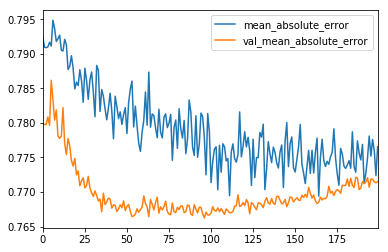

In [0]:
tuned_nn_plot_MAE_test = test_hist.iloc[:, [5,2]].plot.line()
tuned_nn_plot_MAE_test

# Testing Randomization

## Data Segmentation

In [0]:
# Training - Test (70-15-15%)
train, val_and_test = sklearn.model_selection.train_test_split(df, test_size=0.3, random_state=765, shuffle=True)

# Need to split val and test (30%) up
val, test = sklearn.model_selection.train_test_split(val_and_test, test_size=0.5, random_state=765, shuffle=True)

In [34]:
# Neural Network DATA 
Xtrain = train.iloc[:,7:43].astype(np.float32)
Xval = val.iloc[:,7:43].astype(np.float32)
Xtest = test.iloc[:,7:43].astype(np.float32)
Ytrain = train.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
Yval = val.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
Ytest = test.iloc[:,-1].astype(np.float32).values.reshape(-1,1)
Xtrain

,Height_Inches,Wt,40YD,Vertical,Years_in_League,OPP_DEF__Fantasy_Points_Allowed__3_Games,OPP_DEF__Fantasy_Points_Allowed__Last_Game,OWN_DEF__Fantasy_Points_Allowed__3_Games,OWN_DEF__Fantasy_Points_Allowed__Last_Game,Total_Yards__3_Games,Total_Receptions__3_Games,Total_Touchdowns__3_Games,Targets__3_Games,Avg_Depth_of_Target__3_Games,Avg_Score_Differential__3_Games,3rd_Down_Targets__3_Games,4th_Down_Targets__3_Games,Short_Targets__3_Games,Deep_Targets__3_Games,YBC__3_Games,YAC__3_Games,Fantasy_Points_Scored__3_Games,Total_Yards__Last_Games,Total_Receptions__Last_Game,Total_Touchdowns__Last_Game,Targets__Last_Game,Avg_Depth_of_Target__Last_Game,Avg_Score_Differential__Last_Game,3rd_Down_Targets__Last_Game,4th_Down_Targets__Last_Game,Short_Targets__Last_Game,Deep_Targets__Last_Game,YBC__Last_Game,YAC__Last_Game,Fantasy_Points_Scored__Last_Game,home_game_flag
3266,72.0000,204.0000,4.5300,33.0000,1.0000,48.0333,36.1000,40.1667,28.8000,11.3333,1.0000,0.0000,1.6667,6.0000,-3.5556,1.0000,0.0000,1.3333,0.3333,8.6667,2.6667,0.3333,0.0000,0.0000,0.0000,1.0000,8.0000,-11.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4068,70.0000,179.0000,4.3400,36.5000,3.0000,45.1667,42.5000,56.2667,68.6000,45.3333,2.6667,0.6667,6.0000,14.8333,-3.4524,1.6667,0.3333,4.0000,2.0000,34.6667,10.6667,8.7333,63.0000,3.0000,1.0000,4.0000,10.5000,14.5000,1.0000,1.0000,4.0000,0.0000,38.0000,25.0000,13.8000,0.0000
3245,72.0000,201.0000,4.5100,33.5000,4.0000,62.0000,64.1000,35.7333,26.8000,65.0000,5.0000,0.0000,7.3333,9.6131,3.9940,2.6667,0.0000,6.0000,1.3333,45.3333,19.6667,8.8667,59.0000,5.0000,0.0000,7.0000,5.4286,9.7143,3.0000,0.0000,7.0000,0.0000,27.0000,32.0000,8.4000,0.0000
3568,73.0000,214.0000,4.5700,36.0000,0.0000,54.5000,36.2000,42.3667,35.0000,28.0000,2.6667,0.0000,5.6667,9.7652,-6.6061,1.6667,0.3333,4.3333,1.3333,22.6667,5.3333,7.0333,8.0000,1.0000,0.0000,4.0000,11.7500,-7.0000,2.0000,0.0000,3.0000,1.0000,5.0000,3.0000,1.3000,1.0000
4259,70.0000,189.0000,4.3300,36.0000,1.0000,36.8000,19.4000,50.9333,33.1000,56.0000,5.0000,0.3333,7.6667,10.7917,-3.4083,1.3333,0.3333,6.0000,1.6667,47.3333,14.0000,5.8000,29.0000,3.0000,0.0000,5.0000,9.2000,4.2000,1.0000,0.0000,5.0000,0.0000,29.0000,0.0000,4.4000,1.0000
1520,70.0000,199.0000,4.4200,35.0000,3.0000,52.6667,44.5000,32.3333,23.9000,67.6667,4.6667,0.6667,7.0000,7.8095,2.2857,2.0000,0.0000,6.3333,0.6667,37.0000,30.6667,11.8000,93.0000,5.0000,2.0000,7.0000,9.5714,-0.2857,3.0000,0.0000,6.0000,1.0000,51.0000,42.0000,23.8000,1.0000
217,74.0000,215.0000,4.4700,40.5000,9.0000,36.4667,37.0000,44.7667,34.0000,37.3333,2.6667,0.0000,3.3333,12.1111,-0.0000,1.3333,0.3333,2.6667,0.6667,27.0000,15.0000,2.7333,52.0000,4.0000,0.0000,6.0000,8.3333,-6.6667,3.0000,1.0000,6.0000,0.0000,25.0000,27.0000,7.2000,0.0000
1685,75.0000,220.0000,4.3400,38.5000,3.0000,36.0667,43.6000,56.0333,54.0000,78.6667,6.0000,0.0000,9.3333,7.5455,2.7424,2.3333,0.0000,7.6667,1.6667,36.3333,42.3333,8.1667,59.0000,6.0000,0.0000,11.0000,5.8182,0.5455,1.0000,0.0000,10.0000,1.0000,37.0000,22.0000,8.9000,1.0000
5875,73.0000,196.0000,4.6400,32.0000,0.0000,38.9333,24.4000,62.6667,72.8000,0.0000,0.3333,0.0000,1.0000,11.6667,-3.3333,0.0000,0.0000,0.6667,0.3333,10.3333,0.0000,0.3333,0.0000,0.0000,0.0000,1.0000,0.0000,-16.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6361,71.0000,200.0000,4.4100,34.0000,0.0000,72.5333,68.7000,57.1667,38.8000,29.0000,4.0000,0.3333,7.6667,13.3492,-5.2250,2.0000,0.0000,4.3333,2.6667,22.3333,21.3333,10.4667,11.0000,3.0000,0.0000,8.0000,13.7143,-15.8750,3.0000,0.0000,4.0000,3.0000,5.0000,4.0000,2.6000,0.0000


## Data Normalization - Standard Scaler

In [36]:
# Getting Summary Statistics for Rescaling Outputs
train_mean = np.mean(Ytrain)
train_mdn = np.median(Ytrain)
train_stdev = np.std(Ytrain)
val_mean = np.mean(Yval)
val_mdn = np.median(Yval)
val_stdev = np.std(Yval)
test_mean = np.mean(Ytest)
test_mdn = np.median(Ytest)
test_stdev = np.std(Ytest)
train_mean

7.8633056

In [0]:
# Normalizing data using Standard Scaler
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.RobustScaler()

# Normalizing training, validation, and test data individually
Xtrain_norm = scaler.fit_transform(Xtrain)
Xval_norm = scaler.fit_transform(Xval)
Xtest_norm = scaler.fit_transform(Xtest)
Ytrain_norm = scaler.fit_transform(Ytrain)
Yval_norm = scaler.fit_transform(Yval)
Ytest_norm = scaler.fit_transform(Ytest)

## Running Model with Optimized Functions

### Model Structure and Hyperparameters

In [0]:
# Structural Hyperparameters
n_inputs = len(Xtrain_norm)
n_features = len(Xtrain_norm[0])
n_hidden1 = 20
n_hidden2 = 20
n_hidden3 = 5
n_outputs = 1
optimizer = optimizers.SGD(lr=0.01, momentum=0.1)
#optimizer = optimizers.Adam(lr=0.001)

# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden1, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1), 
                             input_shape=(n_features,)
                             ))
    network.add(Dropout(0.2))
    
    # Add layer with a ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden2, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1)
                             ))
    network.add(Dropout(0.2))

    # Add layer with ReLU activation function and bias
    network.add(layers.Dense(units=n_hidden3, activation='linear', 
                             kernel_initializer='uniform', use_bias=True,
                             kernel_constraint=maxnorm(1)
                             ))
    network.add(Dropout(0.2))

    # Add output layer with ReLU activation function
    network.add(layers.Dense(units=n_outputs, activation='relu'))

    # Compile neural network
    network.compile(optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['mean_squared_error', 'mean_absolute_error'])
    
    # Return compiled network
    return network

# Set random seed
np.random.seed(0)

# create model
nn_final = KerasRegressor(build_fn=create_network,  epochs=300, batch_size=100, verbose=0)

### Evaluating Model on Test Data

In [39]:
test_history3 = nn_final.fit(x = Xtest_norm, verbose=0, y = Ytest_norm
                      
                      , validation_data = (Xval_norm, Yval_norm)
)
test_hist3 = pd.DataFrame(test_history3.history)
test_hist3['epoch'] = test_history3.epoch
test_hist3

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,0.9985,0.9985,0.8020,0.9991,0.9991,0.7821,0
1,0.9986,0.9986,0.8010,0.9990,0.9990,0.7834,1
2,0.9968,0.9968,0.8034,0.9974,0.9974,0.7816,2
3,0.9955,0.9955,0.8009,0.9976,0.9976,0.7841,3
4,0.9941,0.9941,0.8025,0.9950,0.9950,0.7832,4
5,0.9928,0.9928,0.8033,0.9941,0.9941,0.7826,5
6,0.9902,0.9902,0.8009,0.9928,0.9928,0.7837,6
7,0.9890,0.9890,0.8040,0.9884,0.9884,0.7804,7
8,0.9849,0.9849,0.7989,0.9871,0.9871,0.7838,8
9,0.9818,0.9818,0.8007,0.9835,0.9835,0.7803,9


In [23]:
test_hist1.loc[test_hist['val_mean_squared_error'].idxmin()]

val_loss                   0.8741
val_mean_squared_error     0.8741
val_mean_absolute_error    0.7611
loss                       0.8564
mean_squared_error         0.8564
mean_absolute_error        0.7651
epoch                     72.0000
Name: 72, dtype: float64

In [32]:
test_hist2.loc[test_hist['val_mean_squared_error'].idxmin()]

val_loss                   0.9065
val_mean_squared_error     0.9065
val_mean_absolute_error    0.7733
loss                       0.8932
mean_squared_error         0.8932
mean_absolute_error        0.7725
epoch                     72.0000
Name: 72, dtype: float64

In [40]:
test_hist3.loc[test_hist['val_mean_squared_error'].idxmin()]

val_loss                   0.8868
val_mean_squared_error     0.8868
val_mean_absolute_error    0.7785
loss                       0.8819
mean_squared_error         0.8819
mean_absolute_error        0.7654
epoch                     72.0000
Name: 72, dtype: float64

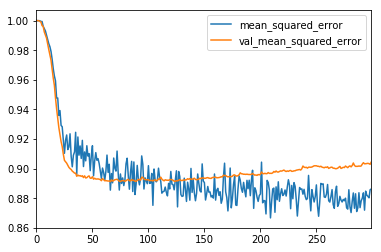

In [0]:
tuned_nn_plot_MSE_test = test_hist.iloc[:, [4,1]].plot.line()
tuned_nn_plot_MSE_test

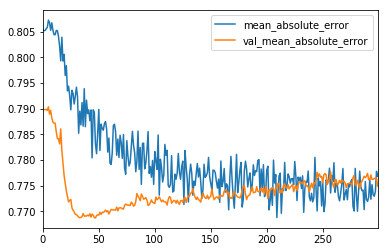

In [0]:
tuned_nn_plot_MAE_test = test_hist.iloc[:, [5,2]].plot.line()
tuned_nn_plot_MAE_test